# Import Required Libraries & Setup Device

In [9]:
import os
import random
import math
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.transforms import ColorJitter, RandomAffine, RandomPerspective
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Error Handling
try:
    from torch.cuda.amp import autocast, GradScaler
except ImportError:
    from contextlib import contextmanager
    @contextmanager
    def autocast(enabled=True):
        yield
    class GradScaler:
        def scale(self, loss):
            return loss
        def unscale_(self, optimizer):
            pass
        def step(self, optimizer):
            optimizer.step()
        def update(self):
            pass

# Set Current Working Directory
from pathlib import Path
project_root = Path.cwd().parent

# Data Augmentation Functions
Define the functions random_horizontal_flip and random_rotation to perform data augmentations on images and landmark coordinates.

In [10]:
def random_horizontal_flip(image, landmarks, p=0.5):
    if random.random() < p:
        image = image.transpose(method=Image.FLIP_LEFT_RIGHT)
        w = image.width
        landmarks[:, 0] = w - landmarks[:, 0]
    return image, landmarks

def random_rotation(image, landmarks, max_angle=15):
    angle = random.uniform(-max_angle, max_angle)
    image = image.rotate(angle, resample=Image.BILINEAR)
    w, h = image.width, image.height
    cx, cy = w / 2, h / 2
    angle_rad = -math.radians(angle)
    rot_matrix = np.array([
        [math.cos(angle_rad), -math.sin(angle_rad)],
        [math.sin(angle_rad), math.cos(angle_rad)]
    ])
    landmarks = landmarks - np.array([cx, cy], dtype=np.float32)
    landmarks = np.dot(landmarks, rot_matrix.T)
    landmarks = landmarks + np.array([cx, cy], dtype=np.float32)
    return image, landmarks

# Dataset Preparation
Implement the FetalLandmarkDataset class which reads image paths and CSV ground truth data, performs image resizing and scales landmarks. Also include extra transformations using torchvision.transforms.

In [11]:
class FetalLandmarkDataset(Dataset):
    def __init__(self, images_dir, csv_file, image_size=(256, 256), augment=False):
        self.images_dir = images_dir
        self.df = pd.read_csv(csv_file)
        self.image_size = image_size
        self.augment = augment

        self.extra_transforms = T.Compose([
            ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            RandomPerspective(distortion_scale=0.4, p=0.5),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_name']
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        landmarks = np.array([
            [row['ofd_1_x'], row['ofd_1_y']],
            [row['ofd_2_x'], row['ofd_2_y']],
            [row['bpd_1_x'], row['bpd_1_y']],
            [row['bpd_2_x'], row['bpd_2_y']]
        ], dtype=np.float32)
        orig_w, orig_h = image.size
        target_w, target_h = self.image_size
        scale_x, scale_y = target_w / orig_w, target_h / orig_h
        landmarks[:, 0] *= scale_x
        landmarks[:, 1] *= scale_y
        image = image.resize(self.image_size, resample=Image.BILINEAR)

        if self.augment:
            image, landmarks = random_horizontal_flip(image, landmarks, p=0.5)
            image, landmarks = random_rotation(image, landmarks, max_angle=15)
            image = self.extra_transforms(image)

        image = T.ToTensor()(image)
        return image, torch.tensor(landmarks, dtype=torch.float)

# Data Loaders Setup
Setup the dataset split (train, validation, test) using random_split and create DataLoader instances for the validation and test sets with a specified batch size.

In [12]:
# Paths and dataset split (using validation or test split)
images_dir = project_root / "Dataset" / "Images"
csv_file = project_root / "Dataset" / "role_challenge_dataset_ground_truth.csv"
full_dataset = FetalLandmarkDataset(images_dir, csv_file, image_size=(256, 256), augment=False)
total_samples = len(full_dataset)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size
_, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print(f"Total samples: {total_samples}")
print(f"Val: {len(val_dataset)}, Test: {len(test_dataset)}")

batch_size = 16
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Total samples: 622
Val: 62, Test: 63


# Model Definition and Weight Loading
Define the ResNet34LandmarkModel using a pretrained ResNet34 and modify its final layer to output 8 keypoints (reshaped into 4 pairs). Load the model weights from a file.

In [13]:
class ResNet34LandmarkModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34LandmarkModel, self).__init__()
        self.backbone = models.resnet34(pretrained=pretrained)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 8)  # 8 keypoints (4 pairs)

    def forward(self, x):
        out = self.backbone(x)
        return out.view(-1, 4, 2)  # Reshape to 4 pairs of keypoints

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34LandmarkModel(pretrained=True).to(device)

# Load the model weights
model.load_state_dict(torch.load(project_root / "Model Weights" / "hypothesis_best_model_weights.pth"))
print("Loaded model weights.")

c:\Users\ANSUMAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ANSUMAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model weights.


# Evaluation Function and Metrics
Implement the evaluate_landmark_model function to calculate average Euclidean error and Percentage of Correct Keypoints (PCK) using the Mean Squared Error loss and euclidean norms.

In [14]:
def evaluate_landmark_model(model, data_loader, device, thresh=3.0):
    model.eval()
    total_error = 0.0
    total_points = 0
    correct = 0
    all_preds = []
    all_gts = []
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for images, landmarks in data_loader:
            images = images.to(device)
            landmarks = landmarks.to(device)
            preds = model(images)
            error = torch.norm(preds - landmarks, dim=2)
            total_error += error.sum().item()
            total_points += error.numel()
            correct += (error < thresh).sum().item()
            all_preds.append(preds.cpu())
            all_gts.append(landmarks.cpu())
    
    avg_error = total_error / total_points
    pck = (correct / total_points) * 100
    print("--- Evaluation Metrics ---")
    print(f"Avg Euclidean Error: {avg_error:.2f} px")
    print(f"PCK (dist < {thresh}px): {pck:.2f}%")
    return avg_error, pck

# Run Model Evaluation
Execute the evaluation function on the validation and test DataLoaders, printing out the evaluation metrics for each.

In [15]:
# Evaluate on validation set
print("----- Validation Evaluation -----")
evaluate_landmark_model(model, val_loader, device=device, thresh=3.0)

# Evaluate on test set
print("\n----- Test Evaluation -----")
evaluate_landmark_model(model, test_loader, device=device, thresh=3.0)

----- Validation Evaluation -----
--- Evaluation Metrics ---
Avg Euclidean Error: 25.17 px
PCK (dist < 3.0px): 7.66%

----- Test Evaluation -----
--- Evaluation Metrics ---
Avg Euclidean Error: 21.29 px
PCK (dist < 3.0px): 4.37%


(21.292728484623016, 4.365079365079365)

# Visualization Function


Ground Truth: [[137.28     44.56296]
 [137.92    212.38518]
 [ 57.6     128.47408]
 [206.72    145.54074]]
Predicted: [[135.90038   38.71411 ]
 [132.96994  215.15205 ]
 [ 53.184563 136.94545 ]
 [208.41852  137.42648 ]]


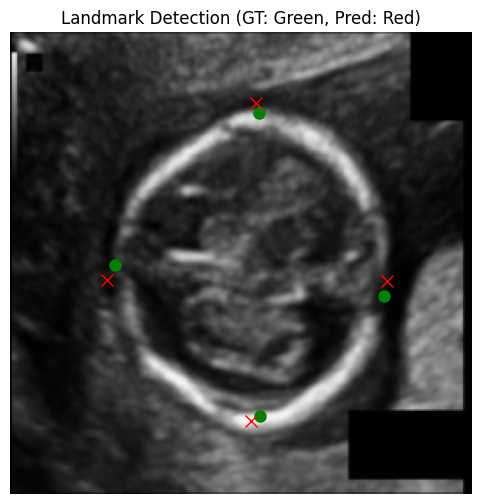

Ground Truth: [[130.56      38.399998]
 [136.64     173.98518 ]
 [ 79.36     111.88148 ]
 [192.       106.19259 ]]
Predicted: [[125.86478  37.14795]
 [125.6903  184.47403]
 [ 66.1766  116.36024]
 [185.65784 116.85602]]


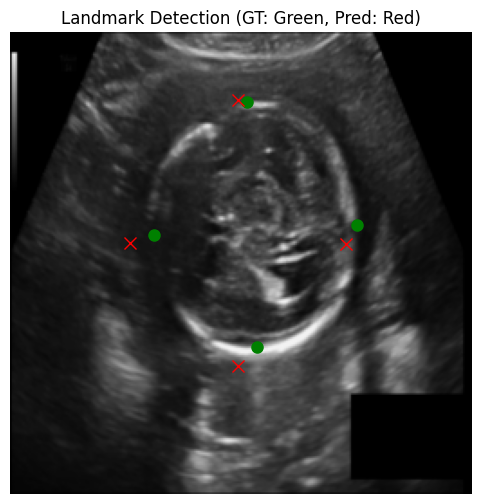

Ground Truth: [[126.079994  32.71111 ]
 [122.56     204.8     ]
 [ 37.44     122.31111 ]
 [194.23999  118.99259 ]]
Predicted: [[124.331856  31.43005 ]
 [119.08235  200.61221 ]
 [ 41.548874 125.59557 ]
 [193.54163  126.04031 ]]


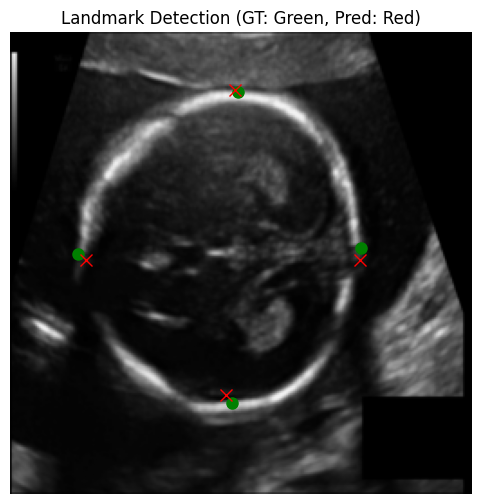

Ground Truth: [[123.52      49.303703]
 [121.28     137.0074  ]
 [ 88.32      66.844444]
 [158.72     111.4074  ]]
Predicted: [[119.79646   60.797756]
 [126.11885  174.60608 ]
 [ 89.00703  111.44835 ]
 [171.24617  105.827225]]


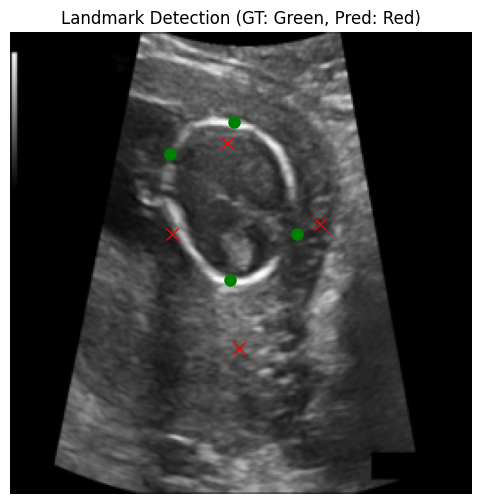

Ground Truth: [[125.439995  56.414814]
 [130.23999  216.65186 ]
 [ 54.079998 145.06667 ]
 [193.92     131.31851 ]]
Predicted: [[128.87718   52.564075]
 [126.84503  213.76033 ]
 [ 53.01825  139.89326 ]
 [198.96149  134.42284 ]]


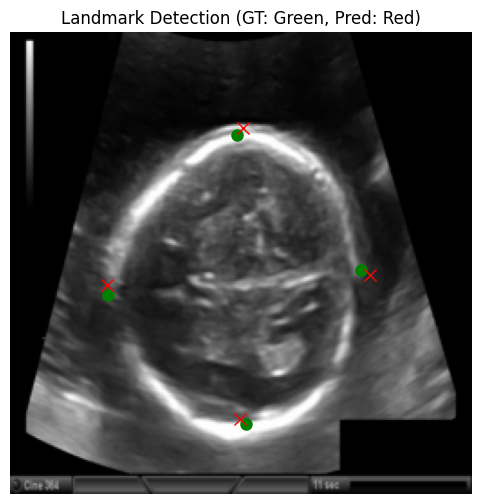

Ground Truth: [[112.64      27.496296]
 [102.72     197.68889 ]
 [ 28.8      112.82963 ]
 [207.04     102.4     ]]
Predicted: [[119.43903   24.71191 ]
 [112.85209  193.27734 ]
 [ 34.802376 118.130974]
 [187.94122  120.366035]]


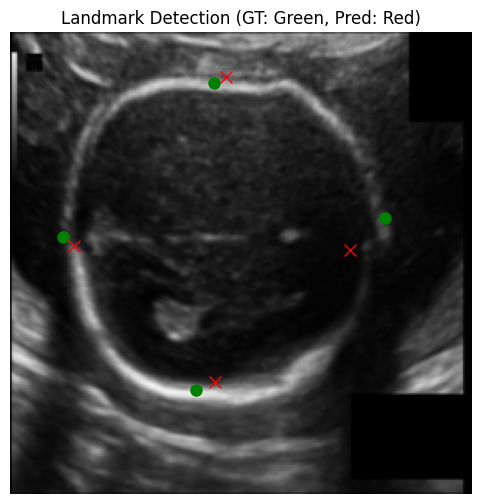

Ground Truth: [[126.71999   10.903704]
 [133.76     219.02222 ]
 [ 31.359999 135.11111 ]
 [224.       110.45926 ]]
Predicted: [[136.36406   20.599705]
 [130.02829  217.33173 ]
 [ 37.9747   130.74423 ]
 [214.60309  136.64725 ]]


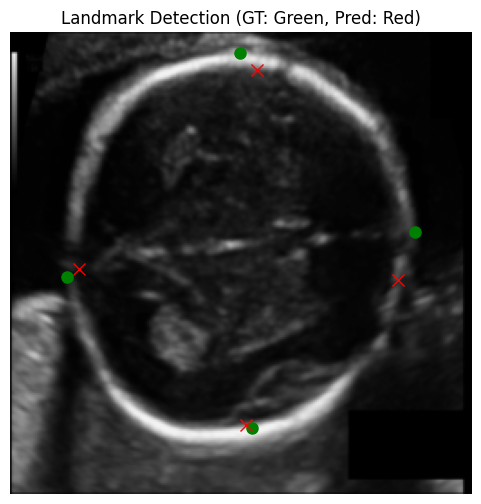

Ground Truth: [[120.8346    33.062733]
 [104.22392  196.95941 ]
 [ 57.648853  82.1845  ]
 [200.63104  144.05904 ]]
Predicted: [[124.29602   25.037025]
 [118.66979  193.70532 ]
 [ 43.007507 118.759125]
 [191.57787  122.480385]]


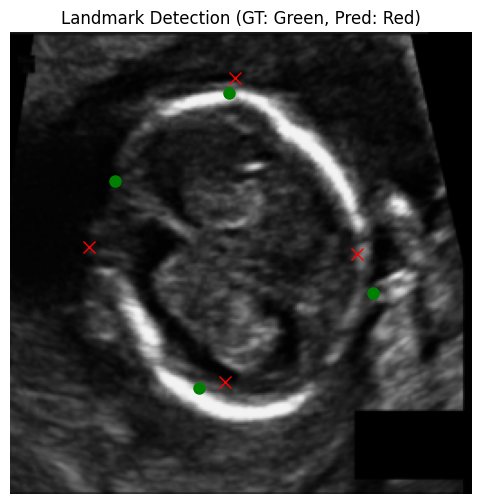

Ground Truth: [[123.2       37.925926]
 [122.88     207.17036 ]
 [ 50.239998 126.1037  ]
 [193.59999  135.58519 ]]
Predicted: [[126.42724   34.773205]
 [121.82192  204.18954 ]
 [ 44.415615 129.61658 ]
 [196.00598  129.21857 ]]


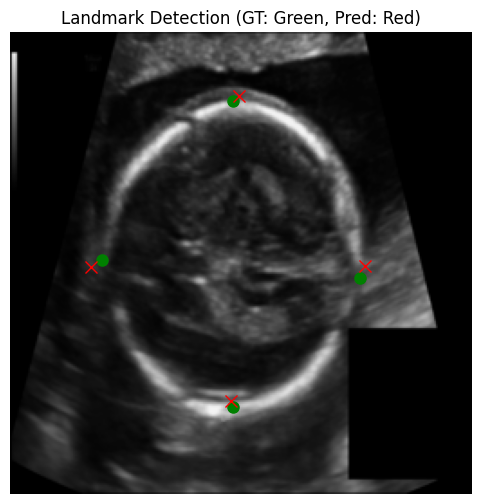

Ground Truth: [[100.479996  72.05926 ]
 [105.28     177.77777 ]
 [ 64.32     116.14815 ]
 [157.76     100.977776]]
Predicted: [[105.327965  66.71342 ]
 [106.028725 173.5769  ]
 [ 60.44549  118.3671  ]
 [157.23982  101.355415]]


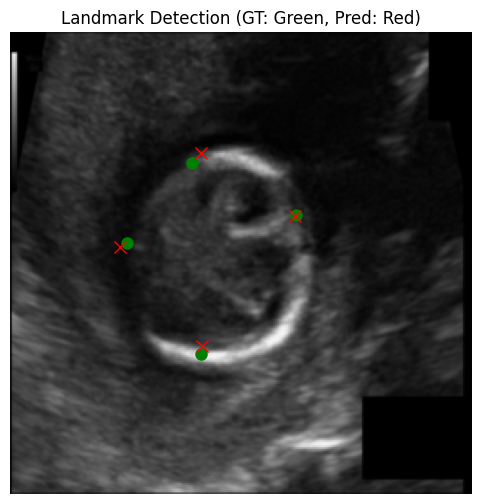

In [16]:
def visualize_landmarks(image_tensor, gt_landmarks, pred_landmarks):
    """
    Plots an image with ground truth landmarks (green circles) 
    and predicted landmarks (red crosses).
    """
    image_np = image_tensor.cpu().permute(1, 2, 0).numpy()
    gt_landmarks = gt_landmarks.cpu().numpy()
    pred_landmarks = pred_landmarks.cpu().numpy()

    print("Ground Truth:", gt_landmarks)
    print("Predicted:", pred_landmarks)

    plt.figure(figsize=(6,6))
    plt.imshow(image_np)
    for (x, y) in gt_landmarks:
        plt.plot(x, y, 'go', markersize=8)
    for (x, y) in pred_landmarks:
        plt.plot(x, y, 'rx', markersize=8)
    plt.title("Landmark Detection (GT: Green, Pred: Red)")
    plt.axis("off")
    plt.show()

# Visualize one sample from test
sample_images, sample_gt = next(iter(test_loader))
sample_images = sample_images.to(device)
with torch.no_grad():
    sample_preds = model(sample_images)
num_samples_to_visualize = 10
for i in range(min(num_samples_to_visualize, len(sample_images))):
    visualize_landmarks(sample_images[i].cpu(), sample_gt[i], sample_preds[i].cpu())